In [5]:
import torch
import torch.nn.functional as F

import numpy as np

In [381]:
class conv_block(torch.nn.Module):
    def __init__(self,D_in,D_out, k):
        super(conv_block, self).__init__() 
        p = np.floor((k - 1) / 2).astype(np.int32)
        self.conv_layer = torch.nn.Conv2d(in_channels= D_in, out_channels= D_out, kernel_size = k ,stride = 2, padding = p) 
        self.conv_layerb = torch.nn.Conv2d(in_channels= D_out, out_channels= D_out, kernel_size = k ,stride = 1, padding = p)
        self.normalize = torch.nn.BatchNorm2d(D_out)
        
    def forward(self, x):
        x = F.elu(self.conv_layer(x)) 
        x = self.normalize(x)
        x = F.elu(self.conv_layerb(x))
        x = self.normalize(x)
        return x 

class upconv(torch.nn.Module):
    def __init__(self,D_in,D_out,k, scale):
        super(upconv, self).__init__()
        self.scale = scale
        p = np.floor((k - 1) / 2).astype(np.int32)
        self.conv = torch.nn.Conv2d(in_channels= D_in, out_channels= D_out, kernel_size = k ,stride = 1, padding = p)
        
    def forward(self,x):
        x = torch.nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        x = self.conv(x)
        return torch.nn.functional.elu(x)
    
class iconv(torch.nn.Module): 
    def __init__(self, D_in, D_out, k):
        super(iconv, self).__init__()
        p = np.floor((k - 1) / 2).astype(np.int32)
        self.conv = torch.nn.Conv2d(in_channels= D_in, out_channels= D_out, kernel_size = k ,stride = 1, padding = p)
    
    def forward(self,x):
        x = self.conv(x)
        return torch.nn.functional.elu(x)    
    
class disp(torch.nn.Module):
    def __init__ (self, D_in, D_out, k, scale):
        super(disp, self).__init__()
        p = 1 
        self.conv =  torch.nn.Conv2d(in_channels= D_in, out_channels= D_out, kernel_size = k ,stride = 1, padding = p)
        self.normalize = torch.nn.BatchNorm2d(2)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.normalize(x)
        return 0.3 * self.sigmoid(x)

In [402]:
class MonoDepthModel(torch.nn.Module):
    def __init__(self):
        super(MonoDepthModel, self).__init__()
        
        #specifiy NN architecture
        
        #encoder 
        self.conv1 = conv_block(D_in=3,D_out=32,k=7)    # h,w /2 
        self.conv2 = conv_block(D_in=32,D_out=64,k=5)   # h,w /4 
        self.conv3 = conv_block(D_in=64,D_out=128,k=3)  # h,w /8
        self.conv4 = conv_block(D_in=128,D_out=256,k=3) # h,w /16
        self.conv5 = conv_block(D_in=256,D_out=512,k=3) # h,w /32
        self.conv6 = conv_block(D_in=512,D_out=512,k=3) # h,w /64
        self.conv7 = conv_block(D_in=512,D_out=512,k=3) # h,w /128 
        #Decoder
        self.upconv7 = upconv(D_in = 512, D_out = 512, k = 3, scale = 2) #h,w / 64
        self.iconv7 = iconv(D_in = 1024, D_out = 512, k = 3)
        self.upconv6 = upconv(D_in = 512, D_out = 512, k = 3, scale = 2) #h,w / 32
        self.iconv6 = iconv(D_in = 1024, D_out = 512, k = 3)
        self.upconv5 = upconv(D_in = 512, D_out = 256, k = 3, scale = 2) #h,w / 16
        self.iconv5 = iconv(D_in = 512, D_out = 256, k = 3)
        #-------------------------------------------------------------#
        self.upconv4 = upconv(D_in = 256, D_out = 128, k = 3, scale = 2) #h,w / 8
        self.iconv4 = iconv(D_in = 256, D_out = 128, k = 3) #WRONG IN THE PAPER?
        self.disp4 = disp(D_in = 128, D_out = 2, k = 3, scale = 2)
        #-------------------------------------------------------------#
        self.upconv3 = upconv(D_in = 128, D_out = 64, k = 3, scale = 2) #h,w / 4
        self.iconv3 = iconv(D_in = 130, D_out = 64, k = 3)   #64+64+2
        self.disp3 = disp(D_in = 64, D_out = 2, k = 3, scale = 2)
        #-------------------------------------------------------------#
        self.upconv2 = upconv(D_in = 64, D_out = 32, k = 3, scale = 2 ) #h,w / 2
        self.iconv2 = iconv(D_in = 66, D_out = 32, k = 3)   #32+32+2
        self.disp2 = disp(D_in = 32, D_out = 2, k = 3, scale = 2)
        #-------------------------------------------------------------#
        self.upconv1 = upconv(D_in = 32, D_out = 16, k = 3, scale = 2) #h,w / 1
        self.iconv1 = iconv(D_in = 18, D_out = 16, k = 3)
        self.disp1 = disp(D_in = 16, D_out = 2, k = 3, scale = 2)
        
                
    def forward(self,x):
        
        print('Encoder')
        #encoder 
        x1 = self.conv1(x)  #conv1b
        x2 = self.conv2(x1) #conv2b
        x3 = self.conv3(x2) #conv3b
        x4 = self.conv4(x3) #conv4b
        x5 = self.conv5(x4) #conv5b 
        x6 = self.conv6(x5) #conv6b
        x7 = self.conv7(x6) #conv7b
        
        encoder = [x1,x2,x3,x4,x5,x6,x7]
        
        for enc in encoder:
            print(enc.size())
        
        
        print ('Decoder')
        #decoder 
        upconv7 = self.upconv7(x7)
        iconv7 = self.iconv7(torch.cat((upconv7,x6),1))
        
        upconv6 = self.upconv6(iconv7)
        iconv6 = self.iconv6(torch.cat((upconv6,x5),1))
        
        upconv5 = self.upconv5(iconv6)
        iconv5 = self.iconv5(torch.cat((upconv5,x4),1))
    
        upconv4 = self.upconv4(iconv5)
        iconv4 = self.iconv4(torch.cat((upconv4,x3),1))
        self.disp4_out = self.disp4(iconv4)
        self.udisp4 = torch.nn.functional.interpolate(self.disp4_out,scale_factor = 2, mode = 'bilinear',align_corners=True)
        
        upconv3 = self.upconv3(iconv4)
        iconv3 = self.iconv3(torch.cat((upconv3,x2,self.udisp4),1))
        self.disp3_out = self.disp3(iconv3)
        self.udisp3 = torch.nn.functional.interpolate(self.disp3_out,scale_factor = 2, mode = 'bilinear',align_corners=True)
        
        upconv2 = self.upconv2(iconv3)
        iconv2 = self.iconv2(torch.cat((upconv2,x1,self.udisp3),1))
        self.disp2_out = self.disp2(iconv2)
        self.udisp2 = torch.nn.functional.interpolate(self.disp2_out,scale_factor = 2, mode = 'bilinear',align_corners=True)
        
        upconv1 = self.upconv1(iconv2)
        iconv1 = self.iconv1(torch.cat((upconv1,self.udisp2),1))
        self.disp1_out = self.disp1(iconv1)
        
        decoder = [iconv7,iconv6,iconv5,iconv4,iconv3,iconv2,iconv1]
        
        for dec in decoder:
            print(dec.size())
         
        return self.disp1_out,self.disp2_out,self.disp3_out,self.disp4_out
    
    

In [403]:
from loss import MonodepthLoss
from data_loader import prepare_dataloader

In [404]:
n_img, data_loader = prepare_dataloader('../../data/kitti/', mode='train', batch_size=2)

Use a dataset with 108 images


In [413]:
model = MonoDepthModel()
image = next(iter(data_loader))['left_image'][0]

In [414]:
d1, d2, d3, d4 = model(image.unsqueeze(0))

Encoder
torch.Size([1, 32, 128, 256])
torch.Size([1, 64, 64, 128])
torch.Size([1, 128, 32, 64])
torch.Size([1, 256, 16, 32])
torch.Size([1, 512, 8, 16])
torch.Size([1, 512, 4, 8])
torch.Size([1, 512, 2, 4])
Decoder
torch.Size([1, 512, 4, 8])
torch.Size([1, 512, 8, 16])
torch.Size([1, 256, 16, 32])
torch.Size([1, 128, 32, 64])
torch.Size([1, 64, 64, 128])
torch.Size([1, 32, 128, 256])
torch.Size([1, 16, 256, 512])


In [415]:
d1

tensor([[[[0.1310, 0.1608, 0.1782,  ..., 0.1820, 0.1826, 0.1808],
          [0.1019, 0.1636, 0.2023,  ..., 0.1473, 0.1716, 0.1877],
          [0.0769, 0.1294, 0.1780,  ..., 0.1325, 0.1494, 0.1541],
          ...,
          [0.1026, 0.1496, 0.1601,  ..., 0.1610, 0.1730, 0.1686],
          [0.0951, 0.1435, 0.1462,  ..., 0.1658, 0.1755, 0.1752],
          [0.0757, 0.1079, 0.1098,  ..., 0.1290, 0.1326, 0.1495]],

         [[0.1522, 0.1622, 0.1589,  ..., 0.1467, 0.1501, 0.1487],
          [0.1365, 0.1472, 0.1448,  ..., 0.1289, 0.1430, 0.1438],
          [0.1267, 0.1405, 0.1491,  ..., 0.1324, 0.1452, 0.1390],
          ...,
          [0.1402, 0.1505, 0.1524,  ..., 0.1531, 0.1516, 0.1471],
          [0.1393, 0.1441, 0.1483,  ..., 0.1470, 0.1483, 0.1501],
          [0.1325, 0.1390, 0.1434,  ..., 0.1499, 0.1512, 0.1504]]]],
       grad_fn=<MulBackward>)

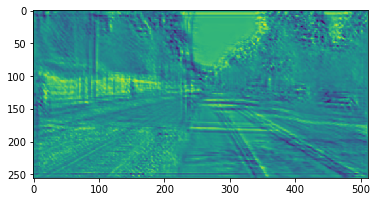

In [416]:
import matplotlib.pyplot as plt
plt.imshow(d1.detach().cpu().numpy()[0, 1])
plt.show()